In [47]:
from transformers import BertForTokenClassification, BertForQuestionAnswering, BertTokenizer
from peft import PeftModel
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

This code is used to visualize the embeddings space of the learned soft prompts.

In [48]:
# Initialize all the data that we have to have before loading the prompts

num_orig_ner_labels = 39 # num of labels in the Turkish NER dataset
name = 'bert-base-multilingual-cased' # model
soft_prompts_path = 'soft_prompts/qa/100/task/30' # path to where load the soft prompts

In [49]:
# Load the model and the soft prompts

model = BertForQuestionAnswering.from_pretrained(name) # Alternate with BertForTokenClassification for NER task
peft_model = PeftModel.from_pretrained(model, soft_prompts_path)
soft_prompts = peft_model.prompt_encoder['default'].embedding.weight.data

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [50]:
# Check the shape of soft prompts, should be [num_toks, hidden_dim]

soft_prompts.shape

torch.Size([100, 768])

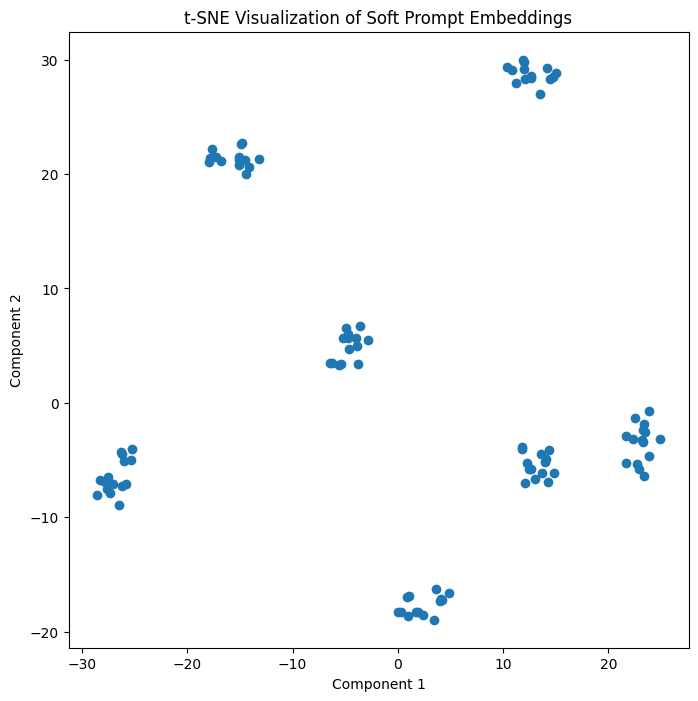

In [51]:
# Convert torch tensor to numpy
soft_prompt_embeddings_np = soft_prompts.detach().cpu().numpy()

# Make a plot of the soft prompts clusters
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
soft_prompt_2d = tsne.fit_transform(soft_prompt_embeddings_np)

plt.figure(figsize=(8, 8))
plt.scatter(soft_prompt_2d[:, 0], soft_prompt_2d[:, 1])
plt.title("t-SNE Visualization of Soft Prompt Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.show()

In [52]:
# Check what the learned embeddings correspond to in the model space
tokenizer = BertTokenizer.from_pretrained(name)
token_embeddings = model.get_input_embeddings().weight.detach().cpu().numpy()

# Compute cosine similarity between soft prompts and token embeddings
similarities = cosine_similarity(soft_prompt_embeddings_np, token_embeddings)

# Get the most similar tokens for each soft prompt embedding
most_similar_token_indices = np.argmax(similarities, axis=1)

# Decode the most similar tokens
for i, idx in enumerate(most_similar_token_indices):
    token = tokenizer.convert_ids_to_tokens(int(idx))
    print(f"Soft prompt {i}  corresponds to token: {token}")

Soft prompt 0  corresponds to token: [CLS]
Soft prompt 1  corresponds to token: question
Soft prompt 2  corresponds to token: answer
Soft prompt 3  corresponds to token: context
Soft prompt 4  corresponds to token: start
Soft prompt 5  corresponds to token: end
Soft prompt 6  corresponds to token: [SEP]
Soft prompt 7  corresponds to token: [CLS]
Soft prompt 8  corresponds to token: question
Soft prompt 9  corresponds to token: answer
Soft prompt 10  corresponds to token: context
Soft prompt 11  corresponds to token: start
Soft prompt 12  corresponds to token: end
Soft prompt 13  corresponds to token: [SEP]
Soft prompt 14  corresponds to token: [CLS]
Soft prompt 15  corresponds to token: question
Soft prompt 16  corresponds to token: answer
Soft prompt 17  corresponds to token: context
Soft prompt 18  corresponds to token: start
Soft prompt 19  corresponds to token: end
Soft prompt 20  corresponds to token: [SEP]
Soft prompt 21  corresponds to token: [CLS]
Soft prompt 22  corresponds to

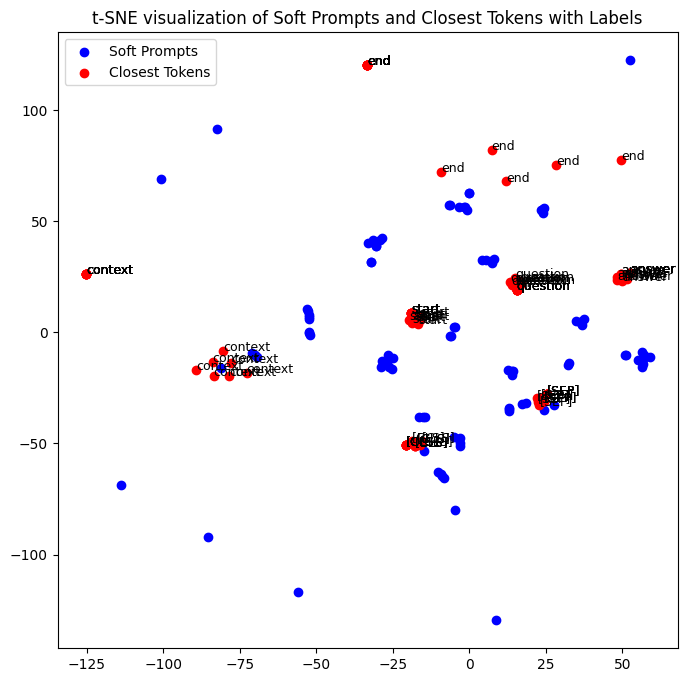

In [53]:
# Plot the embeddings with t-SNE dimensionality reduction

embeddings_to_plot = np.vstack([soft_prompt_embeddings_np, token_embeddings[most_similar_token_indices]])
tsne = TSNE(n_components=2, perplexity=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings_to_plot)

plt.figure(figsize=(8, 8))
plt.scatter(embeddings_2d[:len(soft_prompt_embeddings_np), 0], embeddings_2d[:len(soft_prompt_embeddings_np), 1], label="Soft Prompts", color='blue')
plt.scatter(embeddings_2d[len(soft_prompt_embeddings_np):, 0], embeddings_2d[len(soft_prompt_embeddings_np):, 1], label="Closest Tokens", color='red')

for i, idx in enumerate(most_similar_token_indices):
    token = str(tokenizer.convert_ids_to_tokens(int(idx))) 
    plt.text(embeddings_2d[len(soft_prompt_embeddings_np) + i, 0], embeddings_2d[len(soft_prompt_embeddings_np) + i, 1], token, fontsize=9)

plt.legend()
plt.title("t-SNE visualization of Soft Prompts and Closest Tokens with Labels")
plt.show()